In [1]:
import numpy as np
import matplotlib.pyplot as plt
import myokit

In [2]:
mmt_ap = myokit.load_model('dutta-2017.mmt')
mmt_ikr = myokit.load_model('lei-2019-ikr.mmt')
mmt_ina = myokit.load_model('iyer-2007-ina.mmt')
mmt_ical = myokit.load_model('fink-2008-ical.mmt')

CURRENTS = {
    'ikr': 'ikr.IKr',
    'ina': 'ina.INa',
    'ical': 'ical.ICaL',
}
LOG_CURRENTS = {c: [CURRENTS[c], 'membrane.V'] for c in CURRENTS}
LOG_VC = 'voltage_clamp.I_post'
LOG_VM = 'membrane.V'
LOG = ['membrane.V'] + list(CURRENTS.values())  # For dutta-2017.mmt

SCALINGS = {  # Scaling factors for the currents
    'ikr': 0.66 * 1e-3,
    'ina': 0.1 / 3.33,
    'ical': 3 * 1e-3,
}

DT = 0.1 # ms
TIME = np.arange(0, 2000, DT)  # ms

In [3]:
# Utility functions

def setup(m, label='pace'):
    # Set up the model for pacing
    stim_amp_var = 'stimulus.amplitude'  # For dutta-2017.mmt
    m.set_max_step_size(1e-1)  # ms
    m.set_tolerance(1e-8, 1e-10)
    m.set_constant(stim_amp_var, -80)
    p = myokit.pacing.blocktrain(period=1000,
                                 duration=0.5,
                                 offset=50,
                                 level=1)
    m.set_protocol(p, label=label)
    return m


def detach_currents(m, currents):
    # Detach currents from the model
    m = m.clone()
    paces = []
    for c in currents:
        x = m.get(currents[c])
        if x.is_state():
            x.demote()
        x.set_rhs(0)
        p = 'pace_' + c
        x.set_binding(p)
        paces.append(p)
    return m, paces


def prepare(model, have_leak=True):
    # Prepare the model for voltage-clamping
    model = model.clone()
    model.validate()
    # Check model has name and display_name properties set
    name = model.meta.get('name', None)

    # Check major variables exist and have the right units
    model.timex()

    artefact_variables = []

    vm = model.labelx('membrane_potential')
    i_ion = model.labelx('cellular_current')
    cm = model.labelx('membrane_capacitance')
    artefact_variables.append(cm)
    cm.clamp()

    pace = model.binding('pace')
    if pace is None:
        pace = vm.component().add_variable_allow_renaming('pace')
        pace.set_rhs(0)
        pace.set_binding('pace')

    var_map = {
        'engine.pace': pace,
        'membrane.I_ion': i_ion,
        'membrane.V': vm,
        'cell.Cm': cm,
    }

    am = myokit.load_model('voltage-clamp-ap.mmt')
    model.import_component(am.get('voltage_clamp'), var_map=var_map)
    vc = model.get('voltage_clamp')

    # Voltage-clamp
    assert(vm.is_state())
    rhs = myokit.Minus(
        myokit.Plus(
            myokit.Name(vc.get('V_p')),
            myokit.Name(vc.get('V_offset_eff'))
        ),
        myokit.Name(vm)
    )
    rhs = myokit.Divide(
        rhs, myokit.Multiply(
            myokit.Name(cm),
            myokit.Name(vc.get('R_series'))
        ))

    if have_leak:
        rhs = myokit.Minus(
            rhs,
            myokit.Divide(
                myokit.Plus(
                    myokit.Name(i_ion),
                    myokit.Name(vc.get('I_leak'))
                ), myokit.Name(cm))
            )
    else:
       rhs = myokit.Minus(
           rhs,
           myokit.Divide(
               myokit.Name(i_ion),
               myokit.Name(cm))
           )
    vm.set_rhs(rhs)
    return model

In [4]:
def sample(seed, rs=10e-3):
    # seed: random seed
    # rs: series resistance
    np.random.seed(seed)

    p_voffset_mean = 0  # mV
    p_rseries_mean = rs  # GOhm
    p_cm_mean = 10  # pF
    #p_cprs_mean = 0  # pF
    #gleak = 0

    std_voffset = 2.5  # mV, see paper 1
    std_rseries = 3e-3  # GOhm; LogNormal #1.5
    std_cm = 3  # pF; LogNormal #2.5
    #std_cprs = 1.0  # pF; LogNormal
    std_est_error = 0.05  # 10% error for rseries estimation?

    voffset = np.random.normal(p_voffset_mean, std_voffset)
    rseries_logmean = np.log(p_rseries_mean) \
            - 0.5 * np.log((std_rseries / p_rseries_mean) ** 2 + 1.)
    rseries_scale = np.sqrt(np.log((std_rseries / p_rseries_mean) ** 2 \
            + 1.))
    rseries = np.random.lognormal(rseries_logmean, rseries_scale)
    #cprs_logmean = np.log(p_cprs_mean) \
    #        - 0.5 * np.log((std_cprs / p_cprs_mean) ** 2 + 1.)
    #cprs_scale = np.sqrt(np.log((std_cprs / p_cprs_mean) ** 2 + 1.))
    #cprs = np.random.lognormal(cprs_logmean, cprs_scale)
    cm_logmean = np.log(p_cm_mean) \
            - 0.5 * np.log((std_cm / p_cm_mean) ** 2 + 1.)
    cm_scale = np.sqrt(np.log((std_cm / p_cm_mean) ** 2 + 1.))
    cm = np.random.lognormal(cm_logmean, cm_scale)
    est_rseries = rseries * (1.0 + np.random.normal(0, std_est_error))
    est_cm = cm * (1.0 + np.random.normal(0, std_est_error))
    #est_cprs = cprs * (1.0 + np.random.normal(0, std_est_error))
    return (voffset, rseries, cm, est_rseries, est_cm)


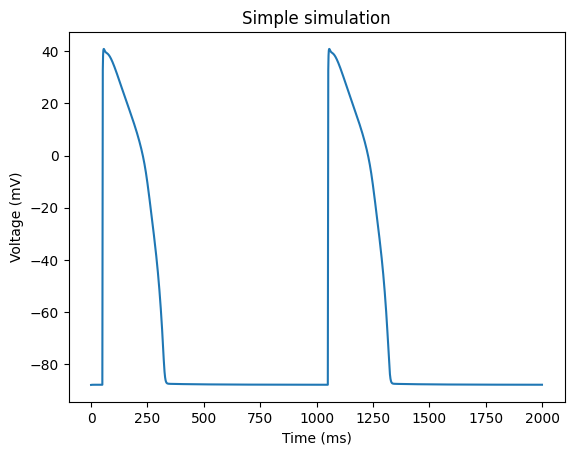

In [5]:
ideal = myokit.Simulation(mmt_ap)
ideal = setup(ideal)

d0 = ideal.run(2000, log_times=TIME, log=LOG)
ideal.reset()

plt.plot(TIME, d0['membrane.V'], c='C0')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Simple simulation')
plt.show()

Simulation error: 0.0002472605766888487 mV


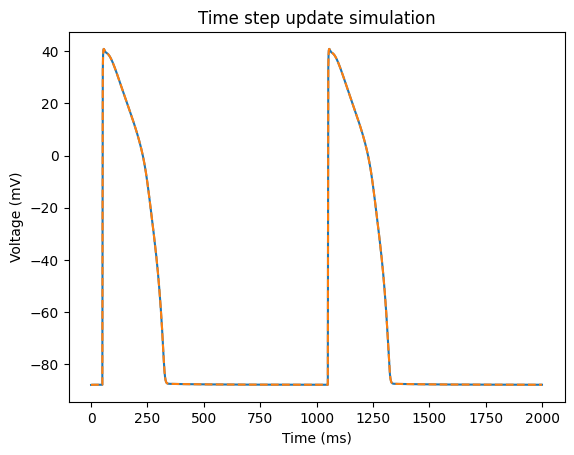

In [6]:
t0 = TIME[0]

ideal.reset()
d1 = ideal.run(DT, log_times=[t0], log=LOG)
ideal.reset()
for i, t1 in enumerate(TIME[1:]):
    d = ideal.run(DT+1e-12, log_times=[t1], log=LOG)
    #print(ideal.time(), t1, d['membrane.V'][0], d0['membrane.V'][i+1])
    for k in LOG: d1[k].append(d[k][0])
    t0 = t1

print('Simulation error:', np.sqrt(np.mean((np.array(d0['membrane.V']) - np.array(d1['membrane.V']))**2)), 'mV')

plt.plot(TIME, d0['membrane.V'], c='C0')
plt.plot(TIME, d1['membrane.V'], c='C1', ls='--')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Time step update simulation')
plt.show()

In [7]:
def run(m, simulation, current_simulation, artifact=False, alphas=0, i_repeat=0):
    # Run simulations with
    # - model `m`,
    # - myokit simulator for the AP model `simulation`,
    # - a list containing each current simulator `current_simulation`,
    # - boolean True for `current_simulation` with artifact setup,
    # - compensation level `alphas`,
    # - random seed setting `i_repeat`.
    #
    # Return a dict containing each current output (keys: CURRENTS) and AP output (keys: LOG).
    if artifact:
            # Only update current_simulation if it has artifact setup
            for j, c in enumerate(current_simulation):
                voffset, rseries, cm, est_rseries, est_cm = sample(i_repeat * 100000 + j)
                #voffset, rseries, cm, est_rseries, est_cm = [0, 1e-4, 1, 1e-4, 1]
                current_simulation[c].set_constant('voltage_clamp.R_series_MOhm', rseries * 1e3)
                current_simulation[c].set_constant('voltage_clamp.R_series_est_MOhm', est_rseries * 1e3)
                current_simulation[c].set_constant('voltage_clamp.V_offset_eff', voffset)
                current_simulation[c].set_constant('cell.Cm', cm)
                current_simulation[c].set_constant('voltage_clamp.Cm_est', est_cm)
                current_simulation[c].set_constant('voltage_clamp.C_prs', 5)
                current_simulation[c].set_constant('voltage_clamp.C_prs_est', 5)
                current_simulation[c].set_constant('voltage_clamp.R_seal_MOhm', 1500)
                current_simulation[c].set_constant('voltage_clamp.R_seal_est_MOhm', 1500 * np.random.normal(1, 0.1))
                current_simulation[c].set_constant('voltage_clamp.alpha_R_percentage', alphas)
                current_simulation[c].set_constant('voltage_clamp.alpha_P_percentage', alphas)

    # Initial simulation at t0
    t0 = TIME[0]
    e1 = dict()
    for c in CURRENTS:
        x = current_simulation[c]
        x.set_protocol(
            myokit.TimeSeriesProtocol([t0], [m.get('membrane.V').value()])
        )
        l = [LOG_VC, LOG_VM] if artifact else LOG_CURRENTS[c]
        e1[c] = x.run(DT, log_times=[t0], log=l)
        e1[c][l[0]][0] *= SCALINGS[c]
        x.reset()

    for c in CURRENTS:
        l = LOG_VC if artifact else CURRENTS[c]
        v = [e1[c][l][0]]
        simulation.set_protocol(myokit.TimeSeriesProtocol([t0], v), label='pace_' + c)
    s1 = simulation.run(DT, log_times=[t0], log=LOG)
    simulation.reset()

    # Update simulation over time
    for i, t1 in enumerate(TIME[1:]):
        T = [t0, t1]
        for c in CURRENTS:
            x = current_simulation[c]
            if i == 0: v = [s1['membrane.V'][-1], s1['membrane.V'][-1]]
            else: v = [s1['membrane.V'][-2], s1['membrane.V'][-1]]
            x.set_protocol(myokit.TimeSeriesProtocol(T, v))
            l = [LOG_VC, LOG_VM] if artifact else LOG_CURRENTS[c]
            e = x.run(DT+1e-12, log_times=[t1], log=l)
            e[l[0]][0] *= SCALINGS[c]
            if artifact:
                e1[c][LOG_VC].append(e[LOG_VC][0])
                e1[c][LOG_VM].append(e[LOG_VM][0])
            else:
                for k in LOG_CURRENTS[c]: e1[c][k].append(e[k][0])

        for c in CURRENTS:
            l = LOG_VC if artifact else CURRENTS[c]
            v = [e1[c][l][-2], e1[c][l][-1]]
            simulation.set_protocol(myokit.TimeSeriesProtocol(T, v), label='pace_' + c)
        s = simulation.run(DT+1e-12, log_times=[t1], log=LOG)
        #print(ideal.time(), t1, s['membrane.V'][0], s0['membrane.V'][i+1])
        for k in LOG: s1[k].append(s[k][0])
        t0 = t1

    return e1, s1

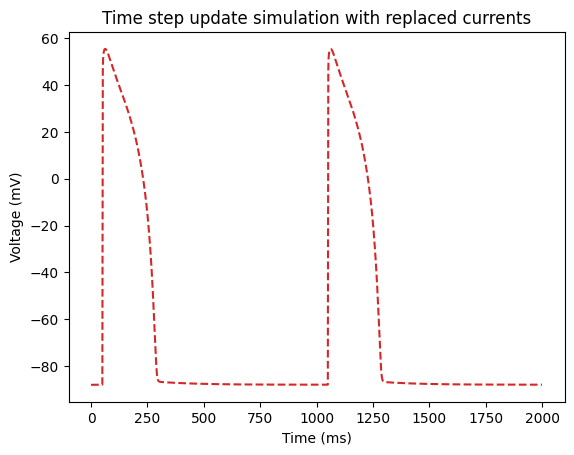

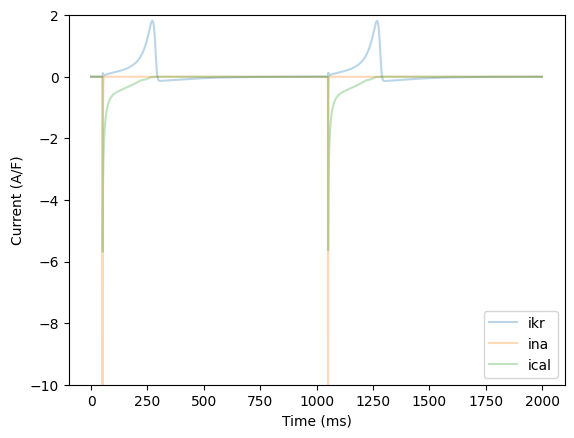

In [8]:
# Test the effect of detaching multiple currents as needed for the next artifact simulation
m, paces = detach_currents(mmt_ap, CURRENTS)

p = dict(pace=None)
for k in paces: p[k] = None

simulation = myokit.Simulation(m, p)

# Set up the current simulation
current_simulation = {
    'ikr': myokit.Simulation(mmt_ikr),
    'ina': myokit.Simulation(mmt_ina),
    'ical': myokit.Simulation(mmt_ical),
}

simulation = setup(simulation, label='pace')

e1, s1 = run(m, simulation, current_simulation, artifact=False)

plt.plot(TIME, s1['membrane.V'], c='C3', ls='--')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Time step update simulation with replaced currents')
plt.show()

for c in CURRENTS:
    plt.plot(TIME, e1[c][CURRENTS[c]], label=c, alpha=0.3)
plt.ylim([-10, 2])
plt.xlabel('Time (ms)')
plt.ylabel('Current (A/F)')
plt.legend()
plt.show()

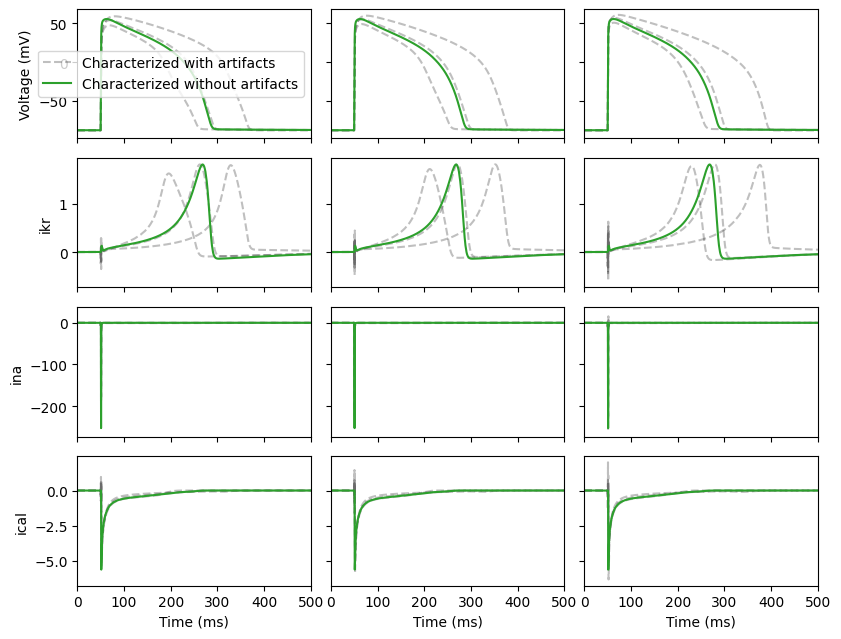

In [14]:
# Add artefacts to the characterization of the currents
# Assuming we could 'perfectly' characterize the observed-artifact-poluted current
CURRENTS = {
    'ikr': 'ikr.IKr',
    'ina': 'ina.INa',
    'ical': 'ical.ICaL',
}

m, paces = detach_currents(mmt_ap, CURRENTS)

p = dict(pace=None)
for k in paces: p[k] = None

simulation = myokit.Simulation(m, p)

# Set up the current simulation
current_simulation = {
    'ikr': myokit.Simulation(prepare(mmt_ikr)),
    'ina': myokit.Simulation(prepare(mmt_ina)),
    'ical': myokit.Simulation(prepare(mmt_ical)),
}

simulation = setup(simulation, label='pace')

# Plot set up
fig, axes = plt.subplots(4, 3, figsize=(8.5, 6.5), sharex=True, sharey='row')

# Run simulations with repeated 'experiments' to generate observed-artifact-poluted currents
alphas = [0, 40, 80]
n_repeats = 3
for i_alpha, alpha in enumerate(alphas):
    for i_repeat in range(n_repeats):
        for c in CURRENTS: current_simulation[c].reset()
        simulation.reset()

        e3, s3 = run(m, simulation, current_simulation, artifact=True, alphas=alpha, i_repeat=i_repeat)
        axes[0, i_alpha].plot(TIME-1000, s3['membrane.V'], c='k', ls='--', alpha=0.25,
                              label='_' if i_repeat else 'Characterized with artifacts')
        for i, c in enumerate(CURRENTS):
            axes[i + 1, i_alpha].plot(TIME-1000, e3[c][LOG_VC], c='k', ls='--', alpha=0.25)

    axes[0, i_alpha].plot(TIME-1000, s1['membrane.V'], c='C2', ls='-', label='Characterized without artifacts')
    for i, c in enumerate(CURRENTS):
        axes[i + 1, i_alpha].plot(TIME-1000, e1[c][CURRENTS[c]], c='C2', ls='-')
    axes[-1, i_alpha].set_xlabel('Time (ms)')

axes[0, 0].set_ylabel('Voltage (mV)')
for i, c in enumerate(CURRENTS):
    axes[i + 1, 0].set_ylabel(c)

axes[0, 0].set_xlim(0, 500)
axes[0, 0].legend()
plt.tight_layout()
plt.savefig('artifact-samples.pdf', format='pdf')
plt.show()

#for c in CURRENTS:
#    plt.plot(TIME, e3[c][LOG_VC], label=c, alpha=0.3)
#plt.ylim([-10, 2])
#plt.xlabel('Time (ms)')
#plt.ylabel('Current (A/F)')
#plt.legend()
#plt.savefig('artifact-samples-currents.pdf', format='pdf')
#plt.show()
